# Introduction

In this notebook, I'll be demonstrating [Pipelines]() in `sklearn`. 

If you haven't already, please refer to [01-data-exploration.ipynb](), as that notebook describes most of the data loading and pre-processing steps that we'll perform at the beginning of this notebook.

## About Pipelines

Pipelines are a **convenience** of the `sklearn` package. You can get by perfectly fine without them, but *with* them, a lot of the boilerplate code is reduced.

As per the [API Reference Page on Pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html):

> Sequentially apply a list of transforms and a final estimator. Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. The transformers in the pipeline can be cached using memory argument.
> 
> The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a ‘__’.

Why should you use them?

- **Convenience and encapsulation**: They can help to keep multiple steps of your code organized, as you only have to call `fit()` and `transform()` once on each dataset
- **Parameter Selection**: You can quickly look at hundreds or thousands of example pipelines and select the best one based on some criteria.
- **Safety**: They reduce errors by having to apply similar steps to different datasets (e.g. training and testing)

To demonstrate this, we will first show what a typical machine learning process looks like *without* pipelines, then rewrite *with* a pipeline. 

# Preliminary Steps

Preliminary steps like package import and data loading will be the same, regardless of which approach you use. So let's do these first, up to (and including) creating a train / test split of the data.

## Imports

In [ ]:
import os
import pandas as pd
import numpy as np

# We use two different plotting libraries, depending on which kind of plot we want
import matplotlib.pyplot as plt
import seaborn as sns

# Set an option for Pandas to display smaller floating-point numbers
pd.options.display.float_format = '{:,.2f}'.format

# SKLearn Imports
from sklearn import metrics

# Turn off warnings
import warnings
warnings.filterwarnings("ignore")

## Data Loading

In [ ]:
# Need to get Google Drive access
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Load the dataset into a Pandas dataframe
data_dir = os.path.join('/content/gdrive/My Drive/classes/be432-2021/notebooks/wisconsin_breast_cancer_data.csv')
df = pd.read_csv(data_dir)

# Since the "ID" column is a unique identifier, we can remove it as a column and instead set it as the index of the dataframe
df = df.set_index('id')

In [ ]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,"1,001.00",0.12,0.28,0.30,0.15,0.24,0.08,1.09,0.91,8.59,153.40,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,"2,019.00",0.16,0.67,0.71,0.27,0.46,0.12
842517,M,20.57,17.77,132.90,"1,326.00",0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,"1,956.00",0.12,0.19,0.24,0.19,0.28,0.09
84300903,M,19.69,21.25,130.00,"1,203.00",0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,94.03,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,"1,709.00",0.14,0.42,0.45,0.24,0.36,0.09
84348301,M,11.42,20.38,77.58,386.10,0.14,0.28,0.24,0.11,0.26,0.10,0.50,1.16,3.44,27.23,0.01,0.07,0.06,0.02,0.06,0.01,14.91,26.50,98.87,567.70,0.21,0.87,0.69,0.26,0.66,0.17
84358402,M,20.29,14.34,135.10,"1,297.00",0.10,0.13,0.20,0.10,0.18,0.06,0.76,0.78,5.44,94.44,0.01,0.02,0.06,0.02,0.02,0.01,22.54,16.67,152.20,"1,575.00",0.14,0.20,0.40,0.16,0.24,0.08


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

## Train/Test Splitting

In [ ]:
# Stratified Split
from sklearn.model_selection import StratifiedShuffleSplit

# Create the splitting object
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

# Apply the split to the data frame using the "diagnosis" column as our label
# NOTE: you need to use `.iloc[]` here instead of `.loc[]` because we changed 
# the index of the dataframe.
for train_index, test_index in split.split(df, df["diagnosis"]):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

# ML Without Pipelines

## Summary

Now that we've split our dataset, let's take a look at the steps we need to complete in order to classify this dataset.

As you have already seen, most ML tasks boil down to a *training* and a *testing* phase. In general, you are *determining what to do* in the training steps, and then *applying those steps* to the testing data.

**Training**

1. Perform label encoding
2. Determine how to scale our features, and scale them
3. Select a subset of the most relevant, uncorrelated features
4. Perform dimensionality reduction using PCA
5. Train a classifier

**Testing**

1. Apply label encoding from #1
2. Apply the scaling from #2
3. Pluck the features selected in #3
4. Apply the dimensionality reduction transform trained in #4
5. Apply the classifier from #5
6. Evaluate the results



We'll go through each of these without pipelines first.

## Training

### Label Encoding

Here we will split the data into training values and training labels. We'll make use of the `LabelEncoder` class to encode the classification labels as numbers.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# First, separate out the values
X_train = train_set.drop(['diagnosis'], axis=1)

# Instantiate the label encoder
label_encoder = LabelEncoder()

# This compact line does the following:
# 1. "Fit" the encoder to the diagnosis column (basically, "here is a list of the category labels for the data")
# 2. "Transform" the labels ("Convert the labels I just told you about to numbers")
# 3. Save the transformed labels as a new variable 
y_train = label_encoder.fit_transform(train_set['diagnosis'])

In [ ]:
X_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8610862,20.18,23.97,143.70,"1,245.00",0.13,0.35,0.38,0.16,0.29,0.08,0.93,1.89,8.65,116.40,0.01,0.07,0.11,0.03,0.08,0.01,23.37,31.72,170.30,"1,623.00",0.16,0.62,0.77,0.25,0.54,0.10
896839,16.03,15.51,105.80,793.20,0.09,0.14,0.12,0.07,0.18,0.06,0.34,0.75,2.63,33.27,0.01,0.03,0.04,0.01,0.01,0.00,18.76,21.98,124.30,"1,070.00",0.14,0.45,0.50,0.20,0.30,0.09
9013594,13.66,15.15,88.27,580.60,0.08,0.08,0.04,0.02,0.18,0.06,0.14,0.54,1.10,11.35,0.01,0.03,0.02,0.01,0.02,0.00,14.54,19.64,97.96,657.00,0.13,0.31,0.26,0.11,0.34,0.10
881094802,17.42,25.56,114.50,948.00,0.10,0.11,0.17,0.07,0.13,0.06,0.53,1.67,3.77,58.53,0.03,0.09,0.14,0.04,0.02,0.01,18.07,28.07,120.40,"1,021.00",0.12,0.18,0.28,0.11,0.16,0.07
861598,14.64,15.24,95.77,651.90,0.11,0.13,0.10,0.07,0.21,0.06,0.51,0.74,3.81,42.76,0.01,0.04,0.04,0.02,0.02,0.00,16.34,18.24,109.40,803.60,0.13,0.31,0.26,0.14,0.32,0.08


In [ ]:
y_train

array([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,

### Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# Let's use standard scaling: 0 mean, 1 standard deviation
# Recall that this will be less sensitive to outliers than `MinMaxScaler`; 
# however, if your data contains a lot of outliers, you may want to use `RobustScaler` instead.
feature_scaler = StandardScaler()

# Fit the feature scaler -- tell it how much to adjust each feature to achieve a 0 mean, unit variance
feature_scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

Note that you can inspect the various "properties" of the trained feature scaler, just like you can with a lot of the objects in scikit-learn. For example, you can see the calculated mean and standard deviation for each feature:

In [ ]:
print(f"Mean feature values, calculated on the training data:")
print(f"{feature_scaler.mean_}")
print()
print(f"Standard Deviations:")
print(f"{feature_scaler.scale_}")

Mean feature values, calculated on the training data:
[1.41265025e+01 1.94382412e+01 9.19044221e+01 6.55325377e+02
 9.58573869e-02 1.02647588e-01 8.84972003e-02 4.85348216e-02
 1.81363568e-01 6.26196734e-02 4.06775377e-01 1.21737688e+00
 2.86762814e+00 4.02961080e+01 6.92423869e-03 2.51423191e-02
 3.22679437e-02 1.15826281e-02 2.04214045e-02 3.76143794e-03
 1.62965930e+01 2.59209045e+01 1.07401181e+02 8.83117588e+02
 1.32163342e-01 2.52405653e-01 2.73916236e-01 1.14698369e-01
 2.91130905e-01 8.38609548e-02]

Standard Deviations:
[3.54873170e+00 4.31701058e+00 2.44169654e+01 3.53238866e+02
 1.43831403e-02 5.34191595e-02 8.10656965e-02 3.92730887e-02
 2.70897513e-02 7.12194920e-03 2.78241059e-01 5.56327961e-01
 2.01248661e+00 4.35073944e+01 2.88515648e-03 1.78870284e-02
 3.30502292e-02 6.24382865e-03 8.42772347e-03 2.68980117e-03
 4.84642464e+00 6.10694992e+00 3.36685807e+01 5.66161567e+02
 2.37659547e-02 1.57310781e-01 2.10611186e-01 6.64105068e-02
 6.41103115e-02 1.82089648e-02]


This will be very interesting / important later with pipelines...

In [ ]:
# Apply the learned feature scaling to the training data
X_train_scaled = feature_scaler.transform(X_train)

In [ ]:
# Verify that the scaling resulted in a mean of 0 and standard deviation of 1
print(f"Mean of scaled features:")
print(f"{X_train_scaled.mean(axis=0)}")

print(f"STD of scaled features:")
print(f"{X_train_scaled.std(axis=0)}")

Mean of scaled features:
[ 4.46320814e-17 -4.40741804e-16  7.93335247e-16  5.35584977e-17
 -1.66254503e-16 -1.00422183e-16 -1.29433036e-16  1.33896244e-17
  1.55096483e-15  1.35123626e-15 -2.23160407e-18 -1.96381158e-16
  0.00000000e+00 -1.33896244e-17 -2.76718905e-16 -1.38917353e-16
  5.35584977e-17  2.71139894e-16 -3.12424570e-16  3.34740610e-18
 -1.78528326e-16 -3.92762316e-16  2.58866072e-16 -2.68908290e-16
 -1.56212285e-17  1.82991534e-16 -1.14927610e-16 -1.31664640e-16
 -3.48130235e-16  1.20506620e-16]
STD of scaled features:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


### Feature Selection

There are [several options](https://scikit-learn.org/stable/modules/feature_selection.html) for feature selection. You can select features in a supervised way (calculating likely "usefulness" with repect to a classification target) or an unsupervised way (variance thresholding, correlation elimination, etc.). In this example though, we will be using the supervised [mutual info classification](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif) test.

Note that we have to ask the selection algorithm how many features we want to retrieve.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif

# Number of features we want to get back
k = 10

# Instantiate
feature_selector = SelectKBest(mutual_info_classif, k=k)

# Fit -- MAKE SURE YOU USE THE SCALED FEATURES!
feature_selector.fit(X_train_scaled, y_train)

# Transform the scaled training data to remove all non-selected features
X_train_selected = feature_selector.transform(X_train_scaled)

In [ ]:
X_train_selected.shape

(398, 10)

You can look at the scores of the features as well by examining the `.scores_` property of the feature selector. 

In [ ]:
print(feature_selector.scores_)

[0.37403361 0.07313565 0.39817971 0.36500042 0.08027013 0.20041507
 0.33518805 0.43643216 0.08205321 0.         0.24562843 0.
 0.24486882 0.34535836 0.         0.03043828 0.09741921 0.13423252
 0.03546968 0.03801369 0.44925975 0.144706   0.45213225 0.44092672
 0.10586363 0.23434642 0.29285903 0.41142764 0.11671274 0.06899733]


With a bit more coding, you can sort these scores and grab the list of feature names, so you can print out the list of most-to-least important features (this can be a good exercise for you to practice coding!).

### Dimensionality Reduction

Again, there are [many ways to do dimensionality reduction](https://scikit-learn.org/stable/modules/unsupervised_reduction.html). Here, we're going to stick to basics: Principal Component Analysis, or PCA.

In [ ]:
from sklearn.decomposition import PCA

# Specify the number of components you want to get back from the system
n_components = 3

feature_reducer = PCA(n_components=n_components)
feature_reducer.fit(X_train_selected)

X_train_reduced = feature_reducer.transform(X_train_selected)

In [ ]:
X_train_reduced.shape

(398, 3)

### Select and Train a Classifier

Once more -- [many, many classifiers](https://scikit-learn.org/stable/supervised_learning.html). And once more, we will cut to the chase and use the support vector machine classifier `SVC()`.

In [ ]:
from sklearn.svm import SVC

clf = SVC()

clf.fit(X_train_reduced, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

We want to have some indication of how well our classifier did, even on the training set (this helps as a check, to see what we might expect on the testing set).

In [ ]:
print(f"SVC Performance on the Training Set: %{clf.score(X_train_reduced, y_train)*100:0.5}")

SVC Performance on the Training Set: %93.97


## Testing

Testing steps require that you simply **apply** the trained objects we just created. To summarize, the objects we have trained (the ones with a `.fit()` method) are:

- `label_encoder`
- `feature_scaler`
- `feature_selector`
- `feature_reducer`
- `clf`

You must make sure that you do not modify these objects at all when applying them to the testing data -- they should be considered **read-only** after the training step.

### Testing Steps

Because the testing steps are all just applications of the previously-trained objects, we can just do them all in one sequential block.

In [ ]:
# Label Encoding
X_test = test_set.drop(['diagnosis'], axis=1)
y_test = label_encoder.transform(test_set['diagnosis'])

# Feature Scaling
X_test_scaled = feature_scaler.transform(X_test)

# Feature Selection
X_test_selected = feature_selector.transform(X_test_scaled)

# Feature Reduction
X_test_reduced = feature_reducer.transform(X_test_selected)

# Classification
X_test_predicted = clf.predict(X_test_reduced)

# Scoring
X_test_acc = clf.score(X_test_reduced, y_test)

print(f"SVC Accuracy on the Testing Set: %{X_test_acc*100:0.5}")

SVC Accuracy on the Testing Set: %93.567


In [ ]:
print(55 * "=")
print("SVC Accuracy Using Standard Approach")
print(55 * "-")
print(metrics.classification_report(y_test, X_test_predicted, target_names=['Benign', 'Malignant']))

SVC Accuracy Using Standard Approach
-------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.91      0.99      0.95       107
   Malignant       0.98      0.84      0.91        64

    accuracy                           0.94       171
   macro avg       0.95      0.92      0.93       171
weighted avg       0.94      0.94      0.93       171



In [ ]:
metrics.confusion_matrix(y_test, X_test_predicted)

array([[106,   1],
       [ 10,  54]])

## Discussion

Now, in a demo, this is pretty straightforward. But what we're doing is very **fragile**: as soon as we start making changes, there is a high likelihood things will break.

- We have 5 trained objects we need to apply in the right sequence
- If we want to change any of these 5, we need to change the corresponding fit / transform methods in both training and testing
- We have multiple parameters (number of features to select, reduced components, SVC parameters) that we need to optimize
- We need to do this process multiple times to get a cross-validation score for different subsets of training and testing data

As soon as you start doing research or edits to this setup, you will start to see what a pain it is to evaluate all of these possible variations. 

Also, it's just very unwieldy to have this much code to do a pretty straightforward series of tasks.

Enter Pipelines.

# ML With Pipelines (Simple)

You can use pipelines in a few different ways, but let's start by "encapsulation": Let's create a pipeline that performs all of the above steps, without anything fancy.

Each step in a pipeline is defined by a *list of tuples*, where each tuple is of the form `('name_of_step', object())`. See below.


In [ ]:
from sklearn.pipeline import Pipeline

# Set up your parameters (same as before)
k = 10
n_components = 3

ml_pipeline = Pipeline([
                        ('feature_scaling', StandardScaler()),
                        ('feature_selection', SelectKBest(mutual_info_classif, k=k)),
                        ('feature_reduction', PCA(n_components=n_components)),
                        ('classifier', SVC())
])

In [ ]:
type(ml_pipeline)

sklearn.pipeline.Pipeline

Now, this is the great part: You can call `fit` on all of this at once!

In [ ]:
ml_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('feature_scaling',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('feature_selection',
                 SelectKBest(k=10,
                             score_func=<function mutual_info_classif at 0x7fb48f92d200>)),
                ('feature_reduction',
                 PCA(copy=True, iterated_power='auto', n_components=3,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('classifier',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

Now every step above is fit to the training data. Now, just apply it to the testing data!

**Note**: If your last step is a classifier, call `.predict()` instead of `.transform()`. The pipeline API (the set of methods you can call) is based on the last step. So you can use the same methods as you would on the SVC() object, like `.predict()` and `.score()`, but not `.transform()` because SVC() doesn't have that method.

In [ ]:
X_test_predicted = ml_pipeline.predict(X_test)
X_test_acc = ml_pipeline.score(X_test, y_test)

print(f"SVC Accuracy on the Testing Set: %{X_test_acc*100:0.5}")

SVC Accuracy on the Testing Set: %93.567


In [ ]:
print(55 * "=")
print("SVC Accuracy Using Pipelines")
print(55 * "-")
print(metrics.classification_report(y_test, X_test_predicted, target_names=['Benign', 'Malignant']))

SVC Accuracy Using Pipelines
-------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.91      0.99      0.95       107
   Malignant       0.98      0.84      0.91        64

    accuracy                           0.94       171
   macro avg       0.95      0.92      0.93       171
weighted avg       0.94      0.94      0.93       171



In [ ]:
metrics.confusion_matrix(y_test, X_test_predicted)

array([[106,   1],
       [ 10,  54]])

So, so much easier -- and now, if you want to make changes to the pipeline, you just have to make them in once place (at the definition of the pipeline) and then re-fit and re-predict your data!

# ML with Pipelines (Cross-Validation)

Okay, so we get the same performance on the test set as before (%93.567). Is this due to the specific train / test split? How do we make sure we aren't overfitting, or that we haven't randomly gotten a good train / test split?

This is where [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) comes into play. You split the dataset several times into mini-training, mini-testing sets, and perform training and testing on each one. Each gives you a score, so you can see how much the accuracy varies as a result of the specific training / testing set.

And here's the thing: Because of the way the methods are designed, you can run CV on the *entire pipeline* at once.



In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(ml_pipeline, X_train, y_train, cv=5)

In [ ]:
print(f"Cross-validation Accuracy Scores:")
for score in scores:
  print(f"  %{score*100:0.5}")
print()
print(f"Average accuracy: %{100* (scores.sum() / len(scores)):0.5}")
print(f"Standard Deviation of scores: {scores.std():0.5}")

Cross-validation Accuracy Scores:
  %95.0
  %96.25
  %91.25
  %91.139
  %88.608

Average accuracy: %92.449
Standard Deviation of scores: 0.02788


You can increase the number of cross-validation folds, but keep in mind that as the number of folds (the `cv` parameter) increases, the size of the testing set will decrease: 

$$\textrm{Testing size per fold} = \frac{1}{\textrm{cv}}$$ 

If you have a small dataset, this might become a problem.

But let's move on to the last and most-valuable part of pipelines: CV parameter selection.

# ML with Pipelines (Parameter Selection)

In our pipeline, there are several spots where we have semi-randomly picked parameter values:

- Feature Selection: `k=10`
- Dimensionality Reduction: `n_components=3`
- Classifier: `C=1.0`, `kernel='rbf'`

Are we sure that these are the best values? Why not `k=20` and `n_components=5`? Maybe the linear kernel does the best when `k=10` and `n_components=3`, but an RBF kernel does better when `k=20` and `n_components=10`?

To test this by hand, we'd have to code a pipeline with each possible combination of each of these parameter values. No fun.

So let's let the code do the work for us!

In [ ]:
from sklearn.model_selection import GridSearchCV

# Re-create pipeline with no specified parameters
ml_pipeline = Pipeline([
                        ('feature_scaling', StandardScaler()),
                        ('feature_selection', SelectKBest(mutual_info_classif)),
                        ('feature_reduction', PCA()),
                        ('classifier', SVC())
])

# Create the parameter set grid to iterate over
k = [20, 25, 30]
n_components = [8, 9, 10]
C = [100, 1000]
kernel = ['rbf', 'linear']

param_grid = {
        'feature_selection__k': k,
        'feature_reduction__n_components': n_components,
        'classifier__C': C,
        'classifier__kernel': kernel
        }

grid = GridSearchCV(ml_pipeline, n_jobs=-1, param_grid=param_grid)

In [ ]:
grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('feature_scaling',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('feature_selection',
                                        SelectKBest(k=10,
                                                    score_func=<function mutual_info_classif at 0x7fb48f92d200>)),
                                       ('feature_reduction',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver...
                                            probability=False,
                            

In [ ]:
# Print out the best parameters of this gridsearch
grid.best_params_

{'classifier__C': 100,
 'classifier__kernel': 'linear',
 'feature_reduction__n_components': 9,
 'feature_selection__k': 25}

In [ ]:
# And the best scores
grid.best_score_

0.9798417721518987

In [ ]:
# Finally, get a performance accuracy on the testing set
X_test_predicted = grid.predict(X_test)
X_test_acc = grid.score(X_test, y_test)
print(f"SVC Accuracy on the Testing Set: %{X_test_acc*100:0.5}")

SVC Accuracy on the Testing Set: %97.076


In [ ]:
print(55 * "=")
print("Result of GridSearchCV to find Optimal Parameters")
print(55 * "-")
print(metrics.classification_report(y_test, X_test_predicted, target_names=['Benign', 'Malignant']))

Result of GridSearchCV to find Optimal Parameters
-------------------------------------------------------
              precision    recall  f1-score   support

      Benign       0.97      0.98      0.98       107
   Malignant       0.97      0.95      0.96        64

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [ ]:
metrics.confusion_matrix(y_test, X_test_predicted)

array([[105,   2],
       [  3,  61]])

## Visualization

In [ ]:
x = np.arange(10)
y = np.arange(20)

In [ ]:

x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
def print_something(*a):
  return np.meshgrid(a)

b = print_something(x,y)

In [ ]:
np.meshgrid(x, y)

[array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]),
 array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
        [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3]

In [ ]:
def make_meshgrid(feature_data, h=.02):
    samples, dims = np.shape(feature_data)

    for dim in range(dims):
      x = feature_data[:,dim]
      d_min, d_max = x.min() - 1, x.max() + 1
      
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [ ]:
def plot_contours(ax, clf, xx, yy, **params):
    # Predict using the entire domain
    Z = clf.predict(domain)
    # Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Z = Z.reshape(xx.shape)
    # out = ax.contourf(xx, yy, Z, **params)
    return out

In [ ]:
best_estimator = grid.best_estimator_

In [ ]:
X_train_pca = best_estimator[:-1].transform(X_train)

In [ ]:
samples, dims = np.shape(X_train_pca)

In [ ]:
range(dims)

range(0, 9)

In [ ]:
X0, X1 = X_train_pca[:, 0], X_train_pca[:, 1]
xx, yy = make_meshgrid(X0, X1)

ValueError: ignored

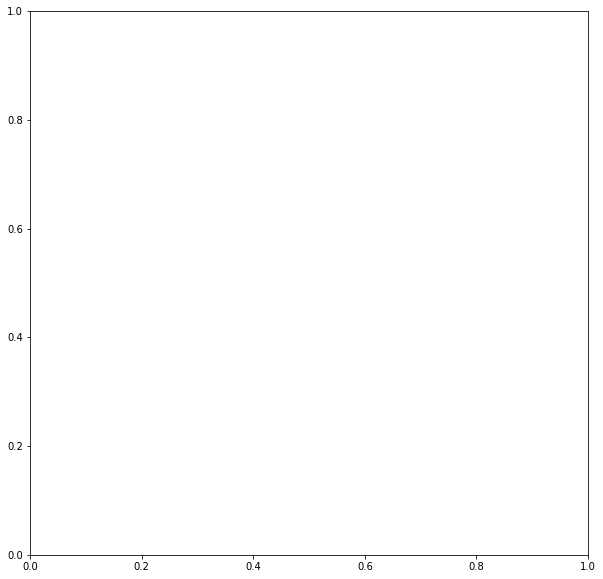

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot_contours(ax, best_estimator[-1], xx, yy, cmap=plt.cm.coolwarm, alpha=0.2)
ax.scatter(X0, X1, c=y_train, cmap=plt.cm.coolwarm, alpha=0.5, s=50, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Malignant vs. Benign SVM')
plt.show()

In [ ]:
X0, X1 = training_values_transformed[:, 0], training_values_transformed[:, 1]
xx, yy = make_meshgrid(X0, X1)

In [ ]:
np.c_[xx.ravel(), yy.ravel()]

In [ ]:
svm_model = SVC()
svm_model.fit(training_values_transformed, training_labels)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plot_contours(ax, svm_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.2)
ax.scatter(X0, X1, c=training_labels['diagnosis_label'], cmap=plt.cm.coolwarm, alpha=0.5, s=50, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Malignant vs. Benign SVM')
plt.show()

In [ ]:
training_idx = ((training_labels==0).values)[:,0]

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)

plot_contours(ax, svm_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.2)
training_points_malig = ax.scatter(X0[training_idx], X1[training_idx], cmap=plt.cm.coolwarm, alpha=0.25, s=50, edgecolors='k')
training_points_benign = ax.scatter(X0[~training_idx], X1[~training_idx], cmap=plt.cm.coolwarm, alpha=0.25, s=50, edgecolors='k')
#testing_points = ax.scatter(testing_values_transformed[:,0], testing_values_transformed[:,1], c='k', alpha=0.75, s=50, edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Malignant vs. Benign SVM')
#ax.legend((training_points_malig, training_points_benign, testing_points), ('Malignant', 'Benign', 'Testing'))
ax.legend((training_points_malig, training_points_benign), ('Malignant', 'Benign'))
plt.show()

In [ ]:
training_points_benign = ax.scatter(X0[training_idx], X1[training_idx], cmap=plt.cm.coolwarm, alpha=0.5, s=50, edgecolors='k')
training_points_malignant = ax.scatter(X0[~training_idx], X1[~training_idx], cmap=plt.cm.coolwarm, alpha=0.5, s=50, edgecolors='k')